Extraction des données : Profils tranverses de la vitesse axiale

In [532]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.metrics import r2_score
from mpl_toolkits.mplot3d import Axes3D

In [533]:
def load_data(file_path, ordonnee):
    dataframes = []
    x_values = []  # List to store the x values
    with open(file_path, 'r') as file:
        lines = file.readlines()
        x_value = None
        data = []
        for line in lines:
            if 'xy/key/label' in line:
                match = re.search('line-(.*)m', line)
                if match is not None:
                    x_value = float(match.group(1))
                    x_values.append(x_value)  # Append the x value to the list
            elif line.strip() == ')':
                df = pd.DataFrame(data, columns=['x', 'y', ordonnee])
                df = df.sort_values(by='y')
                dataframes.append(df)
                data = []
            elif '\t' in line:
                y, u_y = map(float, line.split('\t'))
                data.append([x_value, y, u_y])
    # Concatenate all dataframes into one
    final_df = pd.concat(dataframes)
    return final_df, x_values  # Return the dataframe and the list of x values

#file_path = 'data/ProfilsTransverseVitesseAxiale'
file_path = 'data/ProfilsTransverseVitesseAxiale10Points'
data, x_values = load_data(file_path, 'u(y)')
print(data)
print(x_values)

        x         y      u(y)
0     NaN  0.000000   5.40366
128   NaN  0.000000  14.98740
129   NaN  0.000000  14.98640
130   NaN  0.000000  14.98540
131   NaN  0.000000  14.98450
..    ...       ...       ...
196  0.45  0.092784   4.65023
197  0.45  0.094527   4.65039
198  0.45  0.096310   4.65052
199  0.45  0.098134   4.65061
200  0.45  0.100000   4.65065

[2218 rows x 3 columns]
[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]


On cherche à calculer $\delta(x)$ l'épaisseur de la couche de cisaillement.

La couche de cisaillement est ici définie comme la zone où $\overline{u}$ varie de $U_0 + 0,1 \Delta U$ à $U_0 + 0,9 \Delta U$ où $\Delta U = U_1 - U_0$.

In [534]:
U_0 = 5
U_1 = 15

In [535]:
def shear_layer_thickness(df, x, _U_0 = U_0, _U_1 = U_1):
    # Filter dataframe for given x
    df_x = df[df['x'] == x].copy()
    
    # Calculate delta_U
    #U_0 = df_x['u(y)'].min()
    #U_1 = df_x['u(y)'].max()
    delta_U = _U_1 - _U_0
    
    # Filter dataframe for u(y) values in shear layer
    df_shear = df_x[(df_x['u(y)'] >= _U_0 + 0.1*delta_U) & (df_x['u(y)'] <= _U_0 + 0.9*delta_U)]
    # Calculate and return shear layer thickness
    thickness = df_shear['y'].max() - df_shear['y'].min()
    return thickness

# Test the function
for x in x_values:
    thickness = shear_layer_thickness(data, x)
    print(f"Shear layer thickness at x = {x}: {thickness}")




Shear layer thickness at x = 0.0: 0.0
Shear layer thickness at x = 0.05: 0.004097399999999998
Shear layer thickness at x = 0.1: 0.007730499999999998
Shear layer thickness at x = 0.15: 0.011469
Shear layer thickness at x = 0.2: 0.014853499999999999
Shear layer thickness at x = 0.25: 0.018668000000000004
Shear layer thickness at x = 0.3: 0.0223533
Shear layer thickness at x = 0.35: 0.025582600000000004
Shear layer thickness at x = 0.4: 0.02944563
Shear layer thickness at x = 0.45: 0.03302995


De même on va calculer $y^*$, qui à un $x$ donné est l'ordonnée $y$ telle que $\overline{u}(y^*) = \dfrac{U_0 + U_1}{2}$

In [536]:
print(f'U_0 = {U_0}, U_1 = {U_1}')

def compute_y_star(df, x, _U_0 = U_0, _U_1 = U_1):
    # Filter dataframe for given x
    df_x = df[df['x'] == x].copy()
    
    # Calculate the midpoint of U_0 and U_1
    U_mid = (_U_0 + _U_1) / 2
    
    # Find the y value where U(y) is closest to U_mid
    y_star = df_x.iloc[(df_x['u(y)'] - U_mid).abs().argmin()]['y']
    
    return y_star

# Test the function
for x in x_values:
    y_star = compute_y_star(data, x)
    print(f"y_star at x={x}: {y_star}")
    print(f'U_mid = {(U_0 + U_1) / 2}')
    print(f'velocity at y_star = {data[(data["x"] == x) & (data["y"] == y_star)]["u(y)"].values[0]}')
    print()

U_0 = 5, U_1 = 15
y_star at x=0.0: 0.02
U_mid = 10.0
velocity at y_star = 9.99903

y_star at x=0.05: 0.0206145
U_mid = 10.0
velocity at y_star = 10.0646

y_star at x=0.1: 0.0211001
U_mid = 10.0
velocity at y_star = 10.0215

y_star at x=0.15: 0.0214629
U_mid = 10.0
velocity at y_star = 10.03

y_star at x=0.2: 0.0217576
U_mid = 10.0
velocity at y_star = 10.0241

y_star at x=0.25: 0.0219655
U_mid = 10.0
velocity at y_star = 10.0201

y_star at x=0.3: 0.0220731
U_mid = 10.0
velocity at y_star = 10.0209

y_star at x=0.35: 0.0221832
U_mid = 10.0
velocity at y_star = 9.98867

y_star at x=0.4: 0.0220731
U_mid = 10.0
velocity at y_star = 9.99797

y_star at x=0.45: 0.0218604
U_mid = 10.0
velocity at y_star = 10.0015



Maintenant on peut adimensionnaliser les profils, avec :
- l'abscisse $\dfrac{y-y^*}{\delta}$

- l'ordonnée $\dfrac{\overline{u} - U_0}{U_1 - U_0}$

        x         y      u(y)
0     NaN  0.000000   5.40366
128   NaN  0.000000  14.98740
129   NaN  0.000000  14.98640
130   NaN  0.000000  14.98540
131   NaN  0.000000  14.98450
..    ...       ...       ...
196  0.45  0.092784   4.65023
197  0.45  0.094527   4.65039
198  0.45  0.096310   4.65052
199  0.45  0.098134   4.65061
200  0.45  0.100000   4.65065

[2218 rows x 3 columns]
        x         y      u(y)
0     NaN  0.000000   5.40366
128   NaN  0.000000  14.98740
129   NaN  0.000000  14.98640
130   NaN  0.000000  14.98540
131   NaN  0.000000  14.98450
..    ...       ...       ...
196  0.45  0.092784   4.65023
197  0.45  0.094527   4.65039
198  0.45  0.096310   4.65052
199  0.45  0.098134   4.65061
200  0.45  0.100000   4.65065

[2218 rows x 3 columns]


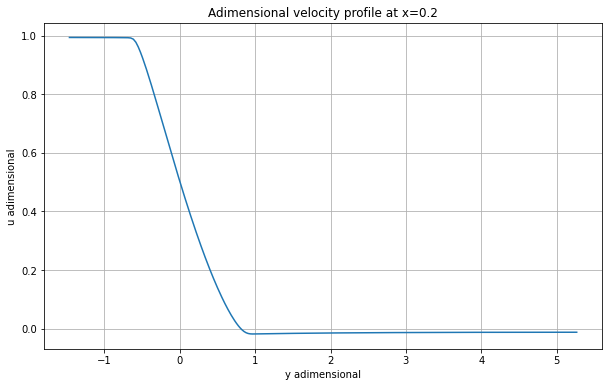

In [537]:
def plot_adimensional(df, x, _U_0 = U_0, _U_1 = U_1):
    # Compute y_star and delta
    y_star = compute_y_star(df, x)
    delta = shear_layer_thickness(df, x)
    print(df)

    df_x = df[df['x'] == x].copy()
    
    # Adimensionalize y and u(y)
    df_x['y_adim'] = (df_x['y'] - y_star) / delta
    df_x['u_adim'] = (df_x['u(y)'] - _U_0) / (_U_1 - _U_0)
    print(df)
    
    # Plot adimensional u(y) vs y
    plt.figure(figsize=(10, 6))
    plt.plot(df_x['y_adim'], df_x['u_adim'])
    plt.xlabel('y adimensional')
    plt.ylabel('u adimensional')
    plt.title(f'Adimensional velocity profile at x={x}')
    plt.grid(True)
    plt.show()

# Test the function
x = 0.2
plot_adimensional(data, x)

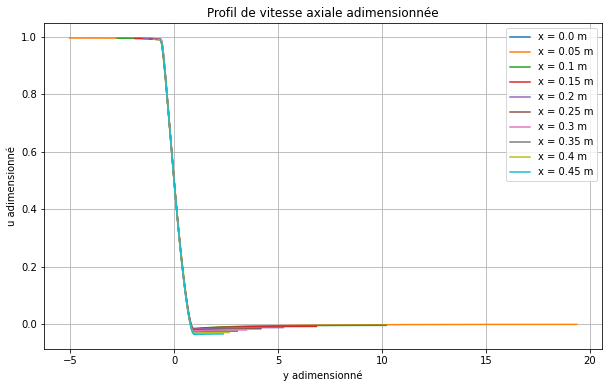

In [538]:
def plot_all_adimensional(df, x_values, _U_0 = U_0, _U_1 = U_1):
    plt.figure(figsize=(10, 6))
    
    for x in x_values:
        # Compute y_star and delta
        y_star = compute_y_star(df, x)
        delta = shear_layer_thickness(df, x)

        df_x = df[df['x'] == x].copy()
        
        # Adimensionalize y and u(y)
        df_x['y_adim'] = (df_x['y'] - y_star) / delta
        df_x['u_adim'] = (df_x['u(y)'] - _U_0) / (_U_1 - _U_0)
        
        # Plot adimensional u(y) vs y with a label
        plt.plot(df_x['y_adim'], df_x['u_adim'], label=f'x = {x} m')
    
    plt.xlabel('y adimensionné')
    plt.ylabel('u adimensionné')
    plt.title('Profil de vitesse axiale adimensionnée')
    #plt.ylim(-2, 2)  # Set the limits of the y-axis
    plt.legend()
    plt.grid(True)
    plt.show()

# Test the function
x_values_coeur = [x for x in x_values if x < 0.462163]
plot_all_adimensional(data, x_values_coeur)

<ipython-input-539-8ef34c5403d0>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('Reds_r')


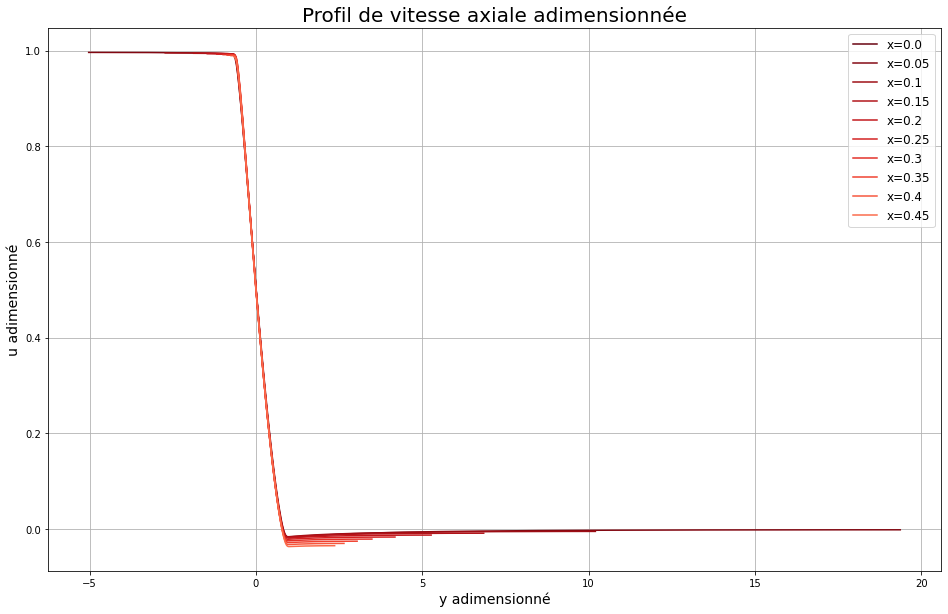

In [539]:
def plot_all_adimensional(df, x_values, _U_0 = U_0, _U_1 = U_1):
    plt.figure(figsize=(16, 10))
    # Create a reversed colormap
    color_map = cm.get_cmap('Reds_r')
    
    # Normalize x_values to [0, 0.5] for the colormap
    x_values_norm = [x / (2 * max(x_values)) for x in x_values]

    for x, x_norm in zip(x_values, x_values_norm):
        # Compute y_star and delta
        y_star = compute_y_star(df, x)
        delta = shear_layer_thickness(df, x)

        df_x = df[df['x'] == x].copy()
        
        # Adimensionalize y and u(y)
        df_x['y_adim'] = (df_x['y'] - y_star) / delta
        df_x['u_adim'] = (df_x['u(y)'] - _U_0) / (_U_1 - _U_0)
        
        # Plot adimensional u(y) vs y with a label
        plt.plot(df_x['y_adim'], df_x['u_adim'], label=f'x={x}', color=color_map(x_norm))
    
    plt.xlabel('y adimensionné', fontsize=14)
    plt.ylabel('u adimensionné', fontsize=14)
    plt.title('Profil de vitesse axiale adimensionnée', fontsize=20)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

# Test the function
x_values_coeur = [x for x in x_values if x < 0.462163]
plot_all_adimensional(data, x_values_coeur)

Full values: K_0 = 0.07278000727272728, K_1 = 0.0003474863636363643, r^2 = 0.999729907358671


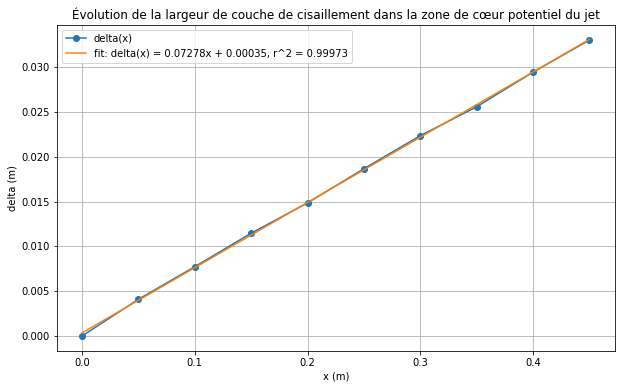

In [540]:
def plot_delta_evolution(df, x_values):
    delta_values = [shear_layer_thickness(df, x) for x in x_values]

    # Perform a linear regression
    K_0, K_1 = np.polyfit(x_values, delta_values, 1)
    
    # Compute the predicted values and the R^2 score
    delta_values_pred = [K_0 * x + K_1 for x in x_values]
    r2 = r2_score(delta_values, delta_values_pred)

    print(f"Full values: K_0 = {K_0}, K_1 = {K_1}, r^2 = {r2}")

    plt.figure(figsize=(10, 6))
    plt.plot(x_values, delta_values, marker='o', linestyle='-', label='delta(x)')
    plt.plot(x_values, delta_values_pred, label=f'fit: delta(x) = {K_0:.5f}x + {K_1:.5f}, r^2 = {r2:.5f}')
    plt.xlabel('x (m)')
    plt.ylabel('delta (m)')
    plt.title('Évolution de la largeur de couche de cisaillement dans la zone de cœur potentiel du jet')
    plt.legend()
    plt.grid(True)
    plt.show()

# Test the function
x_values_coeur = [x for x in x_values if x < 0.462163]
plot_delta_evolution(data, x_values_coeur)

In [541]:
# Load k(y) data
k_data, _ = load_data('data/ProfilsTransverseCinetiqueTurbulence10Points', 'k(y)')

u_data = data.copy()

# Merge k(y) data with existing DataFrame
data = pd.merge(data, k_data, on=['x', 'y'])
print(data)
print(x_values)

         x         y      u(y)      k(y)
0     0.00  0.000000  15.00000  0.014994
1     0.00  0.001245  15.00000  0.015000
2     0.00  0.002416  15.00000  0.015000
3     0.00  0.003517  15.00000  0.015000
4     0.00  0.004553  15.00000  0.015000
...    ...       ...       ...       ...
2023  0.45  0.092784   4.65023  0.004648
2024  0.45  0.094527   4.65039  0.004422
2025  0.45  0.096310   4.65052  0.003934
2026  0.45  0.098134   4.65061  0.002745
2027  0.45  0.100000   4.65065  0.001875

[2028 rows x 4 columns]
[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]


In [542]:
# Load eps(y) data
eps_data, _ = load_data('data/ProfilsTransverseEpsilon10Points', 'eps(y)')

# Merge k(y) data with existing DataFrame
data = pd.merge(data, eps_data, on=['x', 'y'])
print(data)
print(x_values)

         x         y      u(y)      k(y)    eps(y)
0     0.00  0.000000  15.00000  0.014994  0.390314
1     0.00  0.001245  15.00000  0.015000  0.390625
2     0.00  0.002416  15.00000  0.015000  0.390625
3     0.00  0.003517  15.00000  0.015000  0.390625
4     0.00  0.004553  15.00000  0.015000  0.390625
...    ...       ...       ...       ...       ...
2047  0.45  0.092784   4.65023  0.004648  0.044079
2048  0.45  0.094527   4.65039  0.004422  0.043290
2049  0.45  0.096310   4.65052  0.003934  0.041493
2050  0.45  0.098134   4.65061  0.002745  0.037229
2051  0.45  0.100000   4.65065  0.001875  0.068319

[2052 rows x 5 columns]
[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]


In [543]:
# Load mu(y) data
mu_data, _ = load_data('data/ProfilsTransverseViscositeTurbulente10Points', 'mu(y)')

# Merge k(y) data with existing DataFrame
data = pd.merge(data, mu_data, on=['x', 'y'])
print(data)
print(x_values)

         x         y      u(y)      k(y)    eps(y)     mu(y)
0     0.00  0.000000  15.00000  0.014994  0.390314  0.000064
1     0.00  0.001245  15.00000  0.015000  0.390625  0.000064
2     0.00  0.002416  15.00000  0.015000  0.390625  0.000064
3     0.00  0.003517  15.00000  0.015000  0.390625  0.000064
4     0.00  0.004553  15.00000  0.015000  0.390625  0.000064
...    ...       ...       ...       ...       ...       ...
2095  0.45  0.092784   4.65023  0.004648  0.044079  0.000036
2096  0.45  0.094527   4.65039  0.004422  0.043290  0.000033
2097  0.45  0.096310   4.65052  0.003934  0.041493  0.000028
2098  0.45  0.098134   4.65061  0.002745  0.037229  0.000016
2099  0.45  0.100000   4.65065  0.001875  0.068319  0.000008

[2100 rows x 6 columns]
[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]


<ipython-input-544-25d637d113e1>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('Blues_r')


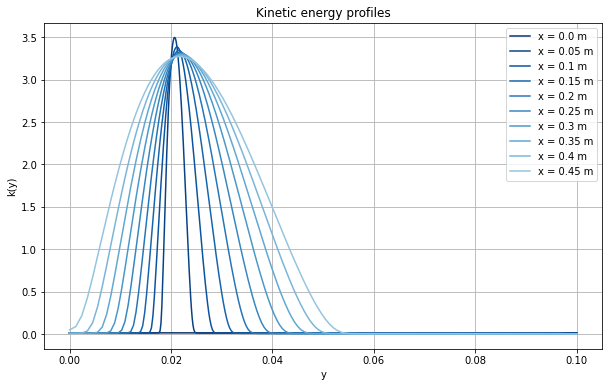

In [544]:
def plot_all_kinetic_energy(df, x_values):
    plt.figure(figsize=(10, 6))
    
    # Create a reversed colormap
    color_map = cm.get_cmap('Blues_r')
    
    # Normalize x_values to [0, 0.6] for the colormap
    x_values_norm = [0 + 0.6 * (x / max(x_values)) for x in x_values]

    for x, x_norm in zip(x_values, x_values_norm):
        df_x = df[df['x'] == x].copy()
        
        # Plot k(y) vs y with a label
        plt.plot(df_x['y'], df_x['k(y)'], label=f'x = {x} m', color=color_map(x_norm))
    
    plt.xlabel('y')
    plt.ylabel('k(y)')
    plt.title('Kinetic energy profiles')
    plt.legend()
    plt.grid(True)
    plt.show()

# Test the function
x_values_coeur = [x for x in x_values if x < 0.462163]
plot_all_kinetic_energy(data, x_values_coeur)

In [545]:
# Le code est très chaotique, il vaudrait mieux importer un gros data et puis ensuite définir des fonctions auxilliaires adaptées,
# plutôt que faire des dataframes distincts parce que les fonctions auxilliaires ont été définies de manière bancale, mais passons.

<ipython-input-546-b00a310c6a69>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('Blues_r')


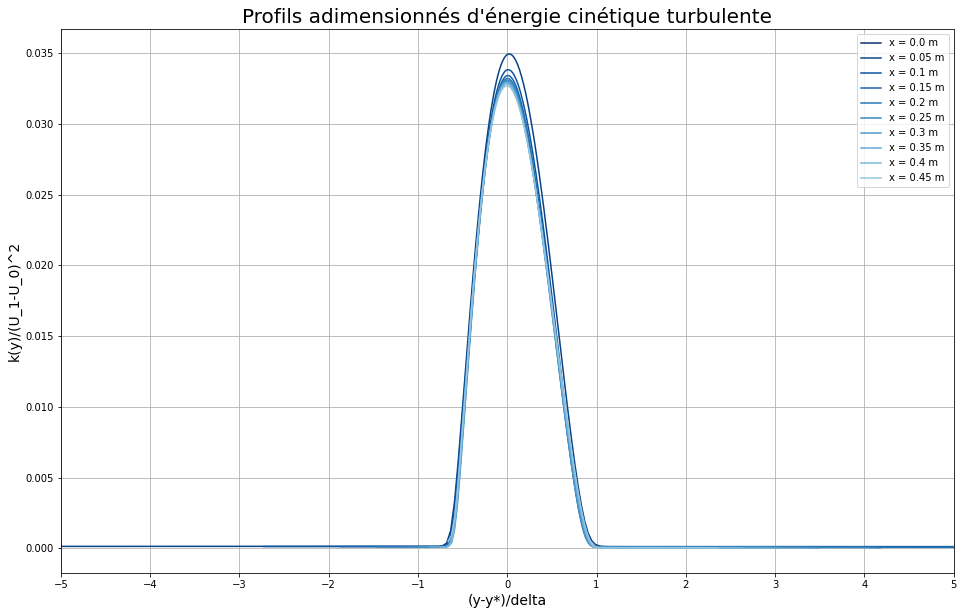

In [546]:
def plot_all_adimensional_kinetic_energy(df, x_values, _U_0 = U_0, _U_1 = U_1):
    plt.figure(figsize=(16, 10))
    
    # Create a reversed colormap
    color_map = cm.get_cmap('Blues_r')
    
    # Normalize x_values to [0, 0.6] for the colormap
    x_values_norm = [0.0 + 0.6 * (x / max(x_values)) for x in x_values]

    for x, x_norm in zip(x_values, x_values_norm):
        # Compute y_star and delta
        y_star = compute_y_star(u_data, x)
        delta = shear_layer_thickness(u_data, x)

        df_x = df[df['x'] == x].copy()
        
        # Adimensionalize y and k(y)
        df_x['y_adim'] = (df_x['y'] - y_star) / delta
        df_x['k_adim'] = df_x['k(y)'] / (_U_1 - _U_0)**2
        
        # Plot adimensional k(y) vs y with a label
        plt.plot(df_x['y_adim'], df_x['k_adim'], label=f'x = {x} m', color=color_map(x_norm))
    
    plt.xlabel('(y-y*)/delta', fontsize=14)
    plt.ylabel('k(y)/(U_1-U_0)^2', fontsize=14)
    plt.title("Profils adimensionnés d'énergie cinétique turbulente", fontsize=20)
    plt.legend()
    plt.grid(True)
    
    # Set x-axis limits and ticks
    plt.xlim(-5, 5)
    plt.xticks(range(-5, 6))
    
    plt.show()

# Test the function
x_values_coeur = [x for x in x_values if x < 0.462163]
plot_all_adimensional_kinetic_energy(data, x_values_coeur)

<ipython-input-547-17f28558c626>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('Blues_r')


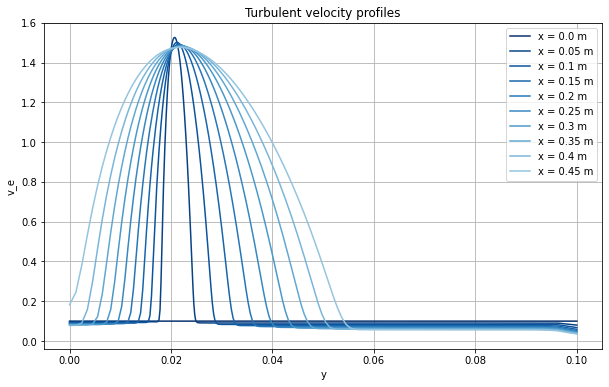

In [547]:
def plot_all_turbulent_velocity(df, x_values):
    plt.figure(figsize=(10, 6))
    
    # Create a reversed colormap
    color_map = cm.get_cmap('Blues_r')
    
    # Normalize x_values to [0, 0.6] for the colormap
    x_values_norm = [0 + 0.6 * (x / max(x_values)) for x in x_values]

    for x, x_norm in zip(x_values, x_values_norm):
        df_x = df[df['x'] == x].copy()
        
        # Compute v_e
        df_x['v_e'] = np.sqrt(df_x['k(y)'] / (3/2))
        
        # Plot v_e vs y with a label
        plt.plot(df_x['y'], df_x['v_e'], label=f'x = {x} m', color=color_map(x_norm))
    
    plt.xlabel('y')
    plt.ylabel('v_e')
    plt.title('Turbulent velocity profiles')
    plt.legend()
    plt.grid(True)
    plt.show()

# Test the function
x_values_coeur = [x for x in x_values if x < 0.462163]
plot_all_turbulent_velocity(data, x_values_coeur)

<ipython-input-548-b918cd772127>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('Greens_r')


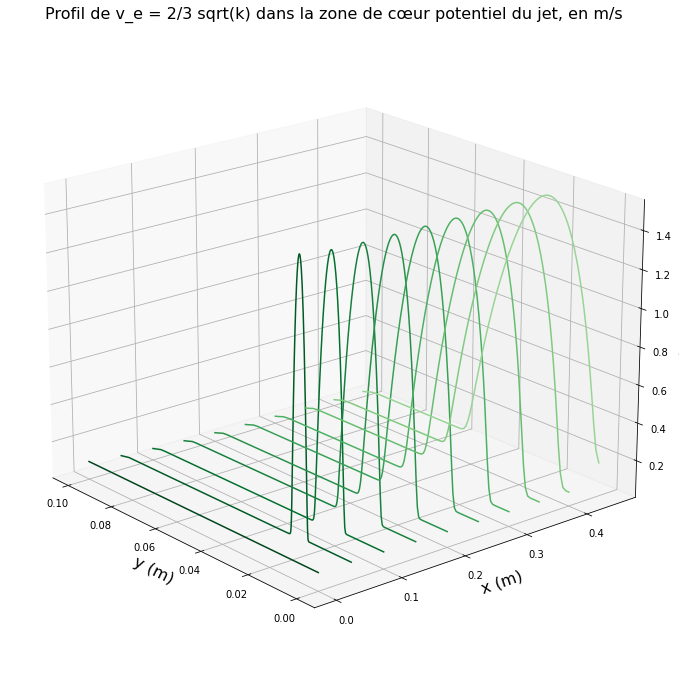

In [548]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

def plot_3d_turbulent_velocity(df, x_values):
    fig = plt.figure(figsize=(16, 12))
    ax = fig.add_subplot(111, projection='3d')
    
    # Create a colormap
    color_map = cm.get_cmap('Greens_r')
    
    # Normalize x_values to [0, 0.6] for the colormap
    x_values_norm = [0.6 * x / max(x_values) for x in x_values]

    # Compute v_e for all x_values and find the min and max
    v_e_values = []
    for x, x_norm in zip(x_values, x_values_norm):
        df_x = df[df['x'] == x].copy()
        
        # Compute v_e
        df_x['v_e'] = np.sqrt(df_x['k(y)'] / (3/2))
        v_e_values.extend(df_x['v_e'].tolist())
        
        # Plot v_e vs y and x with a color from the colormap
        ax.plot(df_x['y'], [x]*len(df_x), df_x['v_e'], color=color_map(x_norm))
    
    ax.set_xlabel('y (m)', fontsize = 16)
    ax.set_ylabel('x (m)', fontsize = 16)
    ax.set_zlabel('v_e (m/s)')
    ax.set_title('Profil de v_e = 2/3 sqrt(k) dans la zone de cœur potentiel du jet, en m/s', fontsize = 16)
    
    # Adjust the viewing angle
    ax.view_init(elev=20, azim=-40)
    
    # Invert the x-axis
    ax.invert_xaxis()
    
    plt.show()

# Test the function
x_values_coeur = [x for x in x_values if x < 0.462163]
plot_3d_turbulent_velocity(data, x_values_coeur)

<ipython-input-549-f01150e165cd>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('plasma')


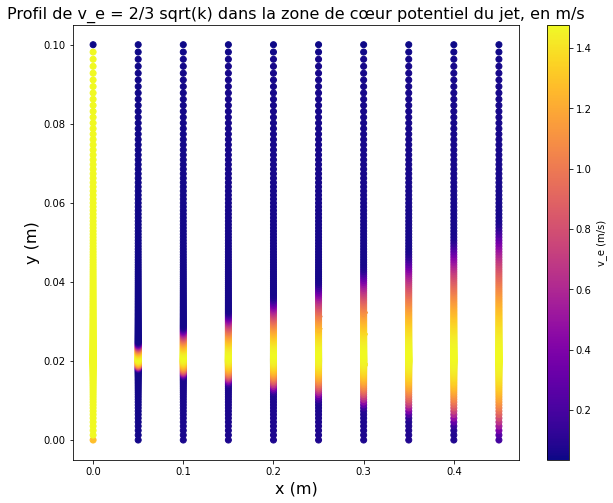

In [549]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

def plot_2d_turbulent_velocity(df, x_values):
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Use a standard colormap
    color_map = cm.get_cmap('plasma')

    # Compute v_e for all x_values and find the min and max
    v_e_values = []
    for x in x_values:
        df_x = df[df['x'] == x].copy()
        
        # Compute v_e
        df_x['v_e'] = np.sqrt(df_x['k(y)'] / (3/2))
        v_e_values.extend(df_x['v_e'].tolist())
        
        # Plot x vs y with a color from the colormap representing v_e
        sc = ax.scatter([x]*len(df_x), df_x['y'], c=df_x['v_e'], cmap=color_map)
    
    ax.set_xlabel('x (m)', fontsize = 16)
    ax.set_ylabel('y (m)', fontsize = 16)
    ax.set_title('Profil de v_e = 2/3 sqrt(k) dans la zone de cœur potentiel du jet, en m/s', fontsize = 16)
    
    # Add a colorbar
    fig.colorbar(sc, label='v_e (m/s)')
    
    plt.show()

# Test the function
x_values_coeur = [x for x in x_values if x < 0.462163]
plot_2d_turbulent_velocity(data, x_values_coeur)

In [550]:
def compute_shear_layer_limit(df, x, _U_0 = U_0, delta_U = U_1 - U_0):
    df_x = df[df['x'] == x].copy()
    
    # Filter the shear layer
    df_shear = df_x[(df_x['u(y)'] >= _U_0 + 0.1*delta_U) & (df_x['u(y)'] <= _U_0 + 0.9*delta_U)]
    
    # Find the y values corresponding to the shear layer
    y_min = df_shear['y'].min()
    y_max = df_shear['y'].max()

    return y_min, y_max

<ipython-input-551-66eaa685b9e5>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('turbo')


Couche de cisaillement en 0.0 m : 0.02 m à 0.02 m
Couche de cisaillement en 0.05 m : 0.0188017 m à 0.0228991 m
Couche de cisaillement en 0.1 m : 0.0176344 m à 0.0253649 m
Couche de cisaillement en 0.15 m : 0.0164355 m à 0.0279045 m
Couche de cisaillement en 0.2 m : 0.0151745 m à 0.030028 m
Couche de cisaillement en 0.25 m : 0.0135642 m à 0.0322322 m
Couche de cisaillement en 0.3 m : 0.0120699 m à 0.0344232 m
Couche de cisaillement en 0.35 m : 0.0109101 m à 0.0364927 m
Couche de cisaillement en 0.4 m : 0.00888147 m à 0.0383271 m
Couche de cisaillement en 0.45 m : 0.00730695 m à 0.0403369 m


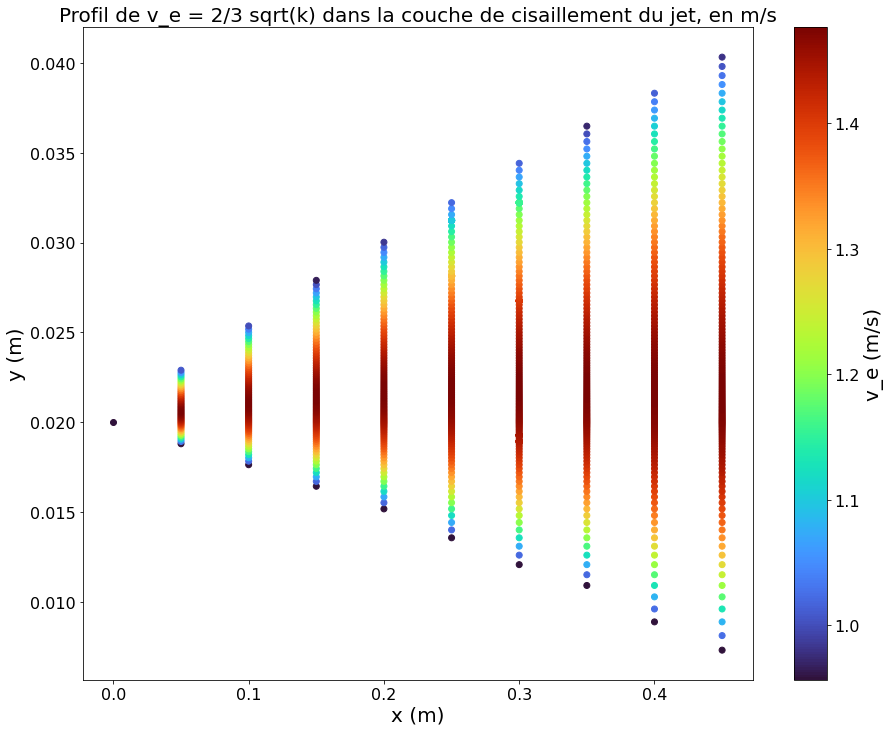

In [551]:
def plot_2d_turbulent_velocity(df, x_values, _U_0 = U_0, delta_U = U_1 - U_0):
    fig, ax = plt.subplots(figsize=(15, 12))  # Increase the size of the figure
    
    # Use a standard colormap
    color_map = cm.get_cmap('turbo')

    # Compute v_e for all x_values and find the min and max
    v_e_values = []
    for x in x_values:
        # Compute the shear layer limits for this x
        _y_min, _y_max = compute_shear_layer_limit(df, x, _U_0, delta_U)
        
        df_x = df[(df['x'] == x) & (df['y'] >= _y_min) & (df['y'] <= _y_max)].copy()
        print(f'Couche de cisaillement en {x} m : {_y_min} m à {_y_max} m')
        
        # Compute v_e
        df_x['v_e'] = np.sqrt(df_x['k(y)'] / (3/2))
        v_e_values.extend(df_x['v_e'].tolist())
        
        # Plot x vs y with a color from the colormap representing v_e
        sc = ax.scatter([x]*len(df_x), df_x['y'], c=df_x['v_e'], cmap=color_map)
    
    ax.set_xlabel('x (m)', fontsize = 20)
    ax.set_ylabel('y (m)', fontsize = 20)
    ax.set_title('Profil de v_e = 2/3 sqrt(k) dans la couche de cisaillement du jet, en m/s', fontsize = 20)
    
    # Increase the size of the tick labels
    ax.tick_params(axis='both', which='major', labelsize=16)
    
    # Add a colorbar
    cbar = fig.colorbar(sc, label='v_e (m/s)')
    cbar.set_label('v_e (m/s)', size=20)  # Increase the size of the colorbar label
    
    # Increase the size of the colorbar tick labels
    cbar.ax.tick_params(labelsize=16)
    
    plt.show()

# Test the function
x_values_coeur = [x for x in x_values if x < 0.462163]
plot_2d_turbulent_velocity(data, x_values_coeur)

<ipython-input-552-2cbd2bcaabca>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('Blues_r')


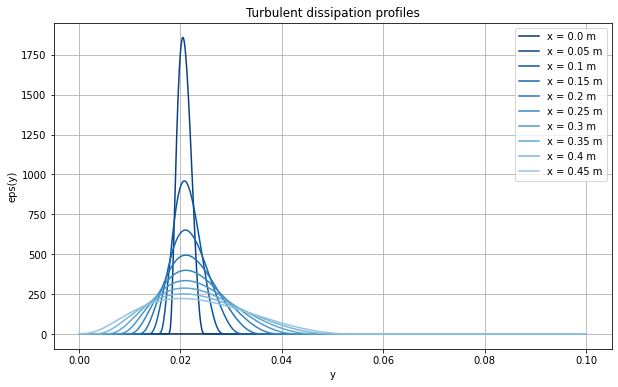

In [552]:
def plot_all_turbulent_dissipation(df, x_values):
    plt.figure(figsize=(10, 6))
    
    # Create a reversed colormap
    color_map = cm.get_cmap('Blues_r')
    
    # Normalize x_values to [0, 0.6] for the colormap
    x_values_norm = [0 + 0.6 * (x / max(x_values)) for x in x_values]

    for x, x_norm in zip(x_values, x_values_norm):
        df_x = df[df['x'] == x].copy()
        
        # Plot eps(y) vs y with a label
        plt.plot(df_x['y'], df_x['eps(y)'], label=f'x = {x} m', color=color_map(x_norm))
    
    plt.xlabel('y')
    plt.ylabel('eps(y)')
    plt.title('Turbulent dissipation profiles')
    plt.legend()
    plt.grid(True)
    plt.show()

# Test the function
x_values_coeur = [x for x in x_values if x < 0.462163]
plot_all_turbulent_dissipation(data, x_values_coeur)

<ipython-input-553-28b8588707ac>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('turbo')


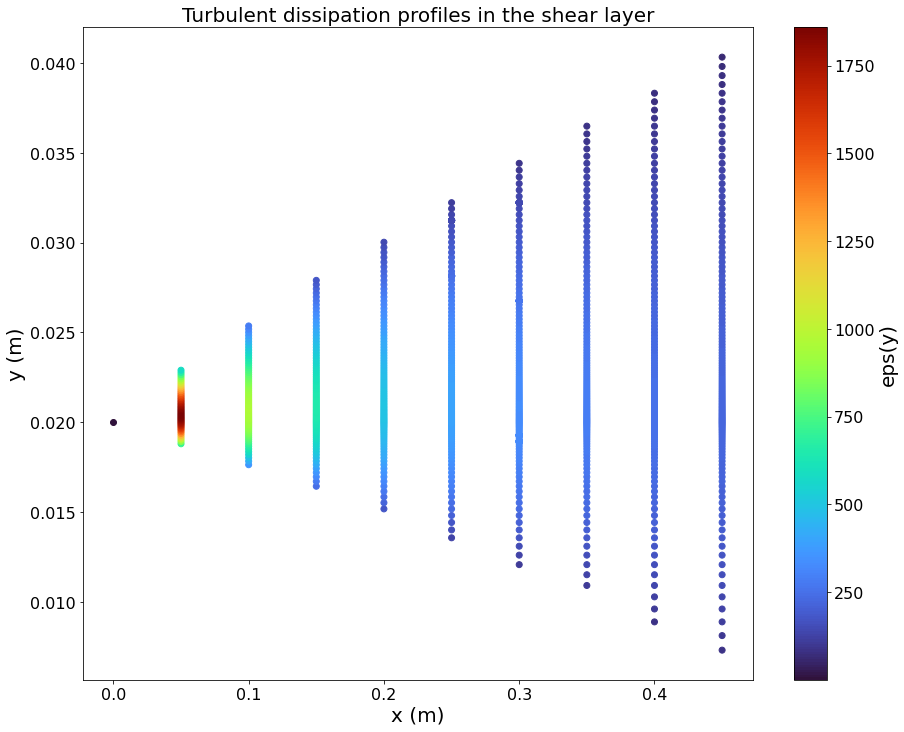

In [553]:
def plot_2d_turbulent_dissipation_shear_layer(df, x_values, _U_0 = U_0, delta_U = U_1 - U_0):
    fig, ax = plt.subplots(figsize=(15, 12))  # Increase the size of the figure
    
    # Use a standard colormap
    color_map = cm.get_cmap('turbo')

    # Compute eps values for all x_values and find the min and max
    eps_values = []
    for x in x_values:
        # Compute the shear layer limits for this x
        _y_min, _y_max = compute_shear_layer_limit(df, x, _U_0, delta_U)
        
        df_x = df[(df['x'] == x) & (df['y'] >= _y_min) & (df['y'] <= _y_max)].copy()
        
        # Add eps values to the list
        eps_values.extend(df_x['eps(y)'].tolist())
        
        # Plot x vs y with a color from the colormap representing eps
        sc = ax.scatter([x]*len(df_x), df_x['y'], c=df_x['eps(y)'], cmap=color_map, vmin=min(eps_values), vmax=max(eps_values))
    
    ax.set_xlabel('x (m)', fontsize = 20)
    ax.set_ylabel('y (m)', fontsize = 20)
    ax.set_title('Turbulent dissipation profiles in the shear layer', fontsize = 20)
    
    # Increase the size of the tick labels
    ax.tick_params(axis='both', which='major', labelsize=16)
    
    # Add a colorbar
    cbar = fig.colorbar(sc, label='eps(y)')
    cbar.set_label('eps(y)', size=20)  # Increase the size of the colorbar label
    
    # Increase the size of the colorbar tick labels
    cbar.ax.tick_params(labelsize=16)
    
    plt.show()

# Test the function
x_values_coeur = [x for x in x_values if x < 0.462163]
plot_2d_turbulent_dissipation_shear_layer(data, x_values_coeur)

In [554]:
'''print(f'U_0 = {U_0}, U_1 = {U_1}')

def plot_2d_turbulent_dissipation_shear_layer(df, x_values, _U_0 = U_0, _delta_U = U_1 - U_0):
    fig, ax = plt.subplots(figsize=(15, 12))  # Increase the size of the figure
    
    # Use a standard colormap
    color_map = cm.get_cmap('turbo')

    # Compute eps values for all x_values and find the min and max
    eps_values = []
    y_star_values = []  # List to store y_star values
    for x in x_values:
        # Compute the shear layer limits for this x
        _y_min, _y_max = compute_shear_layer_limit(df, x, _U_0, _delta_U)
        
        df_x = df[(df['x'] == x) & (df['y'] >= _y_min) & (df['y'] <= _y_max)].copy()
        
        # Add eps values to the list
        eps_values.extend(df_x['eps(y)'].tolist())
        
        # Compute y_star for this x and add it to the list
        y_star = compute_y_star(df, x, _U_0, _delta_U)
        print(f'y_star at x={x}: {y_star}')
        y_star_values.append(y_star)
        
        # Plot x vs y with a color from the colormap representing eps
        sc = ax.scatter([x]*len(df_x), df_x['y'], c=df_x['eps(y)'], cmap=color_map)
    
    # Plot y_star vs x
    ax.plot(x_values, y_star_values, color='red', linewidth=2, label='y*')
    
    ax.set_xlabel('x (m)', fontsize = 20)
    ax.set_ylabel('y (m)', fontsize = 20)
    ax.set_title('Turbulent dissipation profiles in the shear layer', fontsize = 20)
    
    # Increase the size of the tick labels
    ax.tick_params(axis='both', which='major', labelsize=16)
    
    # Add a colorbar
    cbar = fig.colorbar(sc, label='eps(y)')
    cbar.set_label('eps(y)', size=20)  # Increase the size of the colorbar label
    
    # Increase the size of the colorbar tick labels
    cbar.ax.tick_params(labelsize=16)
    
    # Add a legend
    ax.legend(fontsize=16)
    
    plt.show()

#COMMENT CA Y ETOILE BOUGE ?????
for x in x_values:
    y_star = compute_y_star(data, x)
    print(f"y_star at x={x}: {y_star}")
print()
# Test the function
x_values_coeur = [x for x in x_values if x < 0.462163]
plot_2d_turbulent_dissipation_shear_layer(data, x_values_coeur)


# Chelou'''

'print(f\'U_0 = {U_0}, U_1 = {U_1}\')\n\ndef plot_2d_turbulent_dissipation_shear_layer(df, x_values, _U_0 = U_0, _delta_U = U_1 - U_0):\n    fig, ax = plt.subplots(figsize=(15, 12))  # Increase the size of the figure\n    \n    # Use a standard colormap\n    color_map = cm.get_cmap(\'turbo\')\n\n    # Compute eps values for all x_values and find the min and max\n    eps_values = []\n    y_star_values = []  # List to store y_star values\n    for x in x_values:\n        # Compute the shear layer limits for this x\n        _y_min, _y_max = compute_shear_layer_limit(df, x, _U_0, _delta_U)\n        \n        df_x = df[(df[\'x\'] == x) & (df[\'y\'] >= _y_min) & (df[\'y\'] <= _y_max)].copy()\n        \n        # Add eps values to the list\n        eps_values.extend(df_x[\'eps(y)\'].tolist())\n        \n        # Compute y_star for this x and add it to the list\n        y_star = compute_y_star(df, x, _U_0, _delta_U)\n        print(f\'y_star at x={x}: {y_star}\')\n        y_star_values.append(y

<ipython-input-555-e982607b589d>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('turbo')


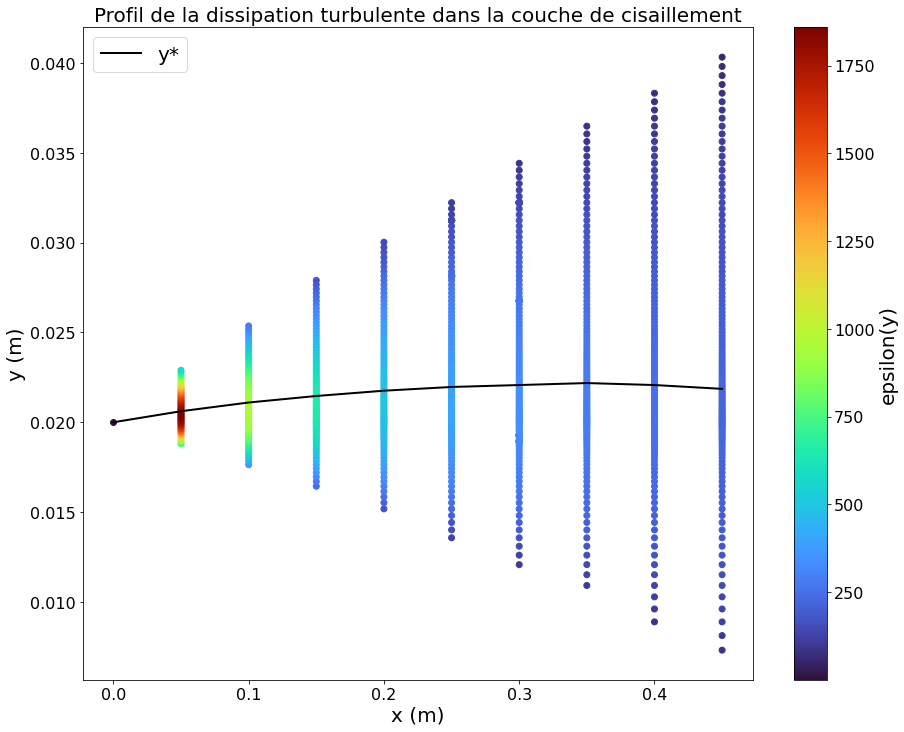

In [555]:
def plot_2d_turbulent_dissipation_shear_layer(df, x_values, _U_0 = U_0, delta_U = U_1 - U_0):
    fig, ax = plt.subplots(figsize=(15, 12))  # Increase the size of the figure
    
    # Use a standard colormap
    color_map = cm.get_cmap('turbo')

    # Compute eps values for all x_values and find the min and max
    eps_values = []
    for x in x_values:
        # Compute the shear layer limits for this x
        _y_min, _y_max = compute_shear_layer_limit(df, x, _U_0, delta_U)
        
        df_x = df[(df['x'] == x) & (df['y'] >= _y_min) & (df['y'] <= _y_max)].copy()
        
        # Add eps values to the list
        eps_values.extend(df_x['eps(y)'].tolist())
        
        # Plot x vs y with a color from the colormap representing eps
        sc = ax.scatter([x]*len(df_x), df_x['y'], c=df_x['eps(y)'], cmap=color_map, vmin=min(eps_values), vmax=max(eps_values))
    
    # Plot y_star vs x outside the loop
    y_star_values = [compute_y_star(data, x) for x in x_values]
    ax.plot(x_values, y_star_values, color='black', linewidth=2, label='y*')
    
    ax.set_xlabel('x (m)', fontsize = 20)
    ax.set_ylabel('y (m)', fontsize = 20)
    ax.set_title('Profil de la dissipation turbulente dans la couche de cisaillement', fontsize = 20)
    
    # Increase the size of the tick labels
    ax.tick_params(axis='both', which='major', labelsize=16)
    
    # Add a colorbar
    cbar = fig.colorbar(sc, label='epsilon(y)')
    cbar.set_label('epsilon(y)', size=20)  # Increase the size of the colorbar label
    
    # Increase the size of the colorbar tick labels
    cbar.ax.tick_params(labelsize=16)
    
    # Add a legend
    ax.legend(loc='upper left', fontsize=20)

    plt.show()

# Test the function
x_values_coeur = [x for x in x_values if x < 0.462163]
plot_2d_turbulent_dissipation_shear_layer(data, x_values_coeur)

0.02
0.0206145
0.0211001
0.0214629
0.0217576
0.0219655
0.0220731
0.0221832
0.0220731
0.0218604


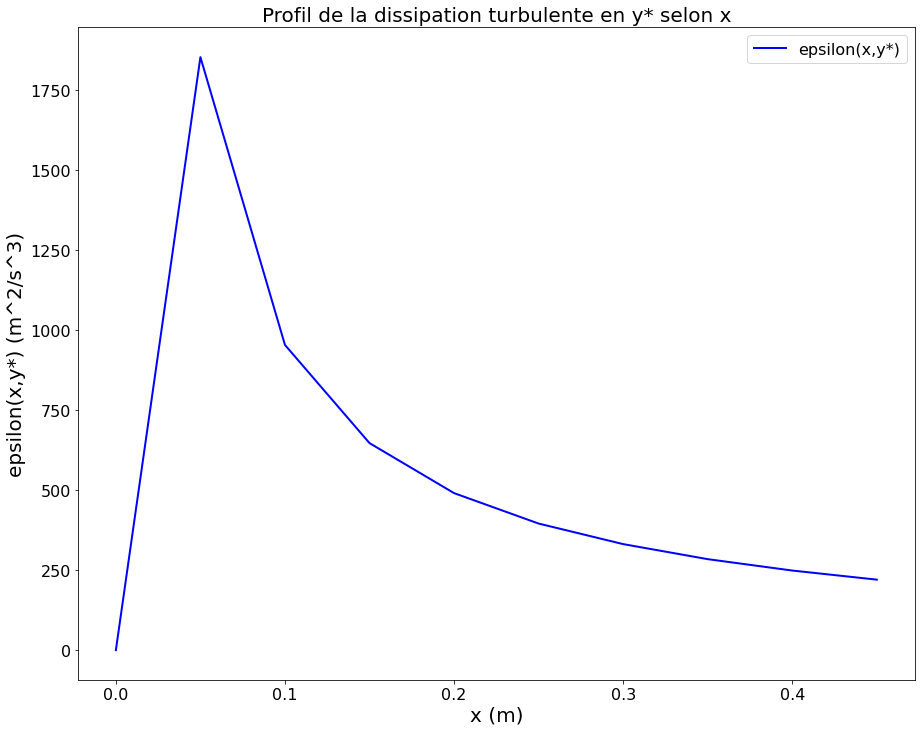

In [556]:
def plot_epsilon_at_y_star(df, x_values, _U_0 = U_0, _U_1 = U_1):
    fig, ax = plt.subplots(figsize=(15, 12))  # Increase the size of the figure

    # Compute y_star and epsilon values for all x_values
    y_star_values = []  # List to store y_star values
    eps_at_y_star_values = []  # List to store epsilon values at y_star
    for x in x_values:
        # Compute y_star for this x
        y_star = compute_y_star(df, x, _U_0, _U_1)
        print(y_star)
        y_star_values.append(y_star)

        # Get the epsilon value at y_star for this x
        eps_at_y_star = df[(df['x'] == x) & (df['y'] == y_star)]['eps(y)'].values[0]
        eps_at_y_star_values.append(eps_at_y_star)

    # Plot epsilon at y_star vs x
    ax.plot(x_values, eps_at_y_star_values, color='blue', linewidth=2, label='epsilon(x,y*)')

    ax.set_xlabel('x (m)', fontsize = 20)
    ax.set_ylabel('epsilon(x,y*) (m^2/s^3)', fontsize = 20)
    ax.set_title('Profil de la dissipation turbulente en y* selon x', fontsize = 20)

    # Increase the size of the tick labels
    ax.tick_params(axis='both', which='major', labelsize=16)

    # Add a legend
    ax.legend(fontsize=16)

    plt.show()

x_values_coeur = [x for x in x_values if x < 0.462163]
plot_epsilon_at_y_star(data, x_values_coeur)

<ipython-input-557-e56a87bb3905>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('Blues_r')


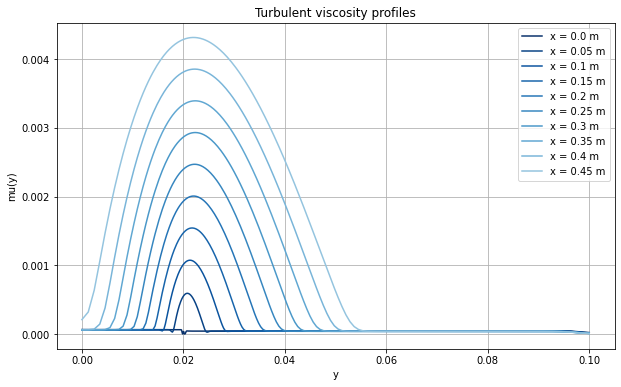

In [557]:
def plot_all_turbulent_viscosity(df, x_values):
    plt.figure(figsize=(10, 6))
    
    # Create a reversed colormap
    color_map = cm.get_cmap('Blues_r')
    
    # Normalize x_values to [0, 0.6] for the colormap
    x_values_norm = [0 + 0.6 * (x / max(x_values)) for x in x_values]

    for x, x_norm in zip(x_values, x_values_norm):
        df_x = df[df['x'] == x].copy()
        
        # Plot mu(y) vs y with a label
        plt.plot(df_x['y'], df_x['mu(y)'], label=f'x = {x} m', color=color_map(x_norm))
    
    plt.xlabel('y')
    plt.ylabel('mu(y)')
    plt.title('Turbulent viscosity profiles')
    plt.legend()
    plt.grid(True)
    plt.show()

# Test the function
x_values_coeur = [x for x in x_values if x < 0.462163]
plot_all_turbulent_viscosity(data, x_values_coeur)

<ipython-input-558-98ff0c4a0e98>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('turbo')


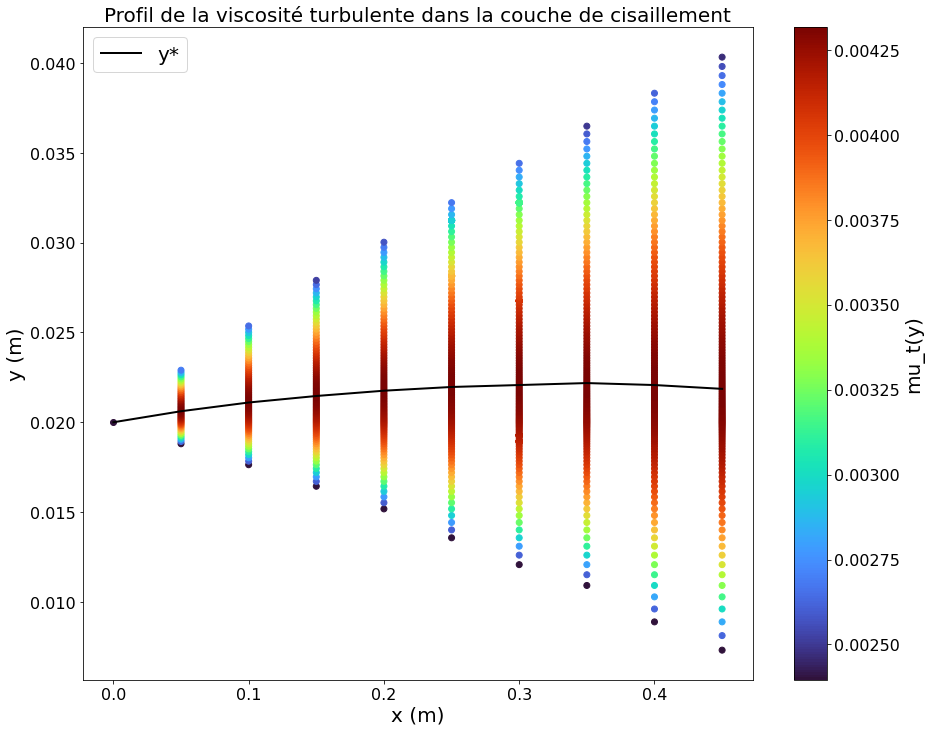

In [558]:
def plot_2d_turbulent_viscosity_shear_layer(df, x_values, _U_0 = U_0, delta_U = U_1 - U_0):
    fig, ax = plt.subplots(figsize=(15, 12))  # Increase the size of the figure
    
    # Use a standard colormap
    color_map = cm.get_cmap('turbo')

    # Compute mu values for all x_values and find the min and max
    mu_values = []
    for x in x_values:
        # Compute the shear layer limits for this x
        _y_min, _y_max = compute_shear_layer_limit(df, x, _U_0, delta_U)
        
        df_x = df[(df['x'] == x) & (df['y'] >= _y_min) & (df['y'] <= _y_max)].copy()
        
        # Add mu values to the list
        mu_values.extend(df_x['mu(y)'].tolist())
        
        # Plot x vs y with a color from the colormap representing mu
        sc = ax.scatter([x]*len(df_x), df_x['y'], c=df_x['mu(y)'], cmap=color_map)#, vmin=min(mu_values), vmax=max(mu_values))
    
    # Plot y_star vs x outside the loop
    y_star_values = [compute_y_star(data, x) for x in x_values]
    ax.plot(x_values, y_star_values, color='black', linewidth=2, label='y*')
    
    ax.set_xlabel('x (m)', fontsize = 20)
    ax.set_ylabel('y (m)', fontsize = 20)
    ax.set_title('Profil de la viscosité turbulente dans la couche de cisaillement', fontsize = 20)
    
    # Increase the size of the tick labels
    ax.tick_params(axis='both', which='major', labelsize=16)
    
    # Add a colorbar
    cbar = fig.colorbar(sc, label='mu_t(y)')
    cbar.set_label('mu_t(y)', size=20)  # Increase the size of the colorbar label
    
    # Increase the size of the colorbar tick labels
    cbar.ax.tick_params(labelsize=16)
    
    # Add a legend
    ax.legend(loc='upper left', fontsize=20)

    plt.show()

# Test the function
x_values_coeur = [x for x in x_values if x < 0.462163]
plot_2d_turbulent_viscosity_shear_layer(data, x_values_coeur)

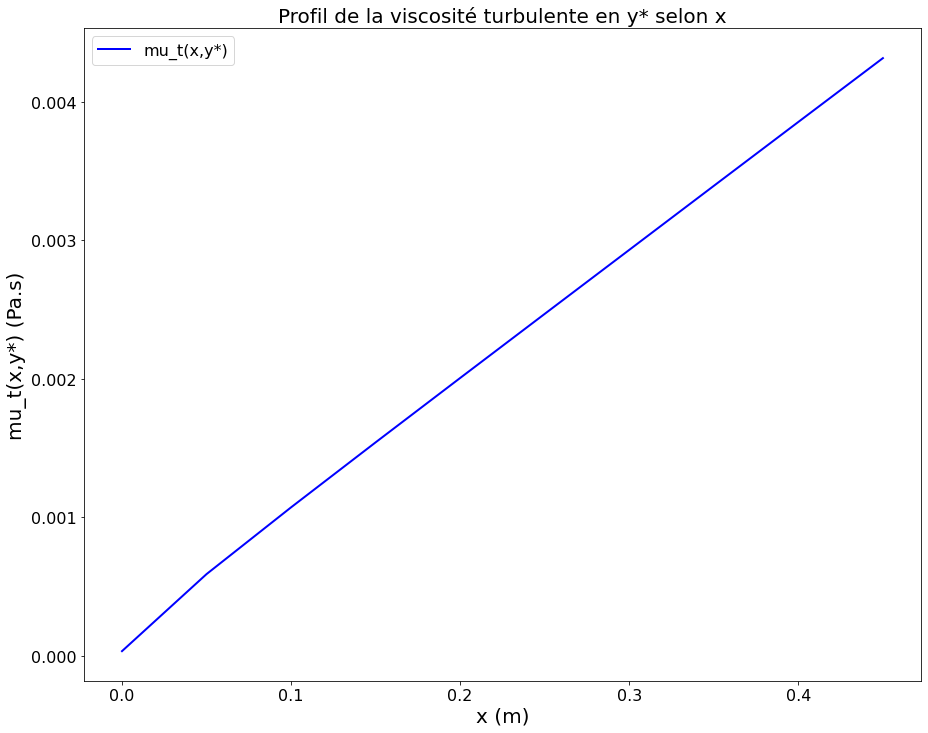

In [559]:
def plot_mu_at_y_star(df, x_values, _U_0 = U_0, _U_1 = U_1):
    fig, ax = plt.subplots(figsize=(15, 12))  # Increase the size of the figure

    # Compute y_star and mu values for all x_values
    y_star_values = []  # List to store y_star values
    mu_at_y_star_values = []  # List to store mu values at y_star
    for x in x_values:
        # Compute y_star for this x
        y_star = compute_y_star(df, x, _U_0, _U_1)
        y_star_values.append(y_star)

        # Get the mu value at y_star for this x
        mu_at_y_star = df[(df['x'] == x) & (df['y'] == y_star)]['mu(y)'].values[0]
        mu_at_y_star_values.append(mu_at_y_star)

    # Plot mu at y_star vs x
    ax.plot(x_values, mu_at_y_star_values, color='blue', linewidth=2, label='mu_t(x,y*)')

    ax.set_xlabel('x (m)', fontsize = 20)
    ax.set_ylabel('mu_t(x,y*) (Pa.s)', fontsize = 20)
    ax.set_title('Profil de la viscosité turbulente en y* selon x', fontsize = 20)

    # Increase the size of the tick labels
    ax.tick_params(axis='both', which='major', labelsize=16)

    # Add a legend
    ax.legend(fontsize=16)

    plt.show()

x_values_coeur = [x for x in x_values if x < 0.462163]
plot_mu_at_y_star(data, x_values_coeur)

In [560]:
# Add a new column for l_e
data['l_e'] = (2/3 * data['k(y)'])**(3/2) / data['eps(y)']

<ipython-input-561-735dbb10e79e>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('rainbow')


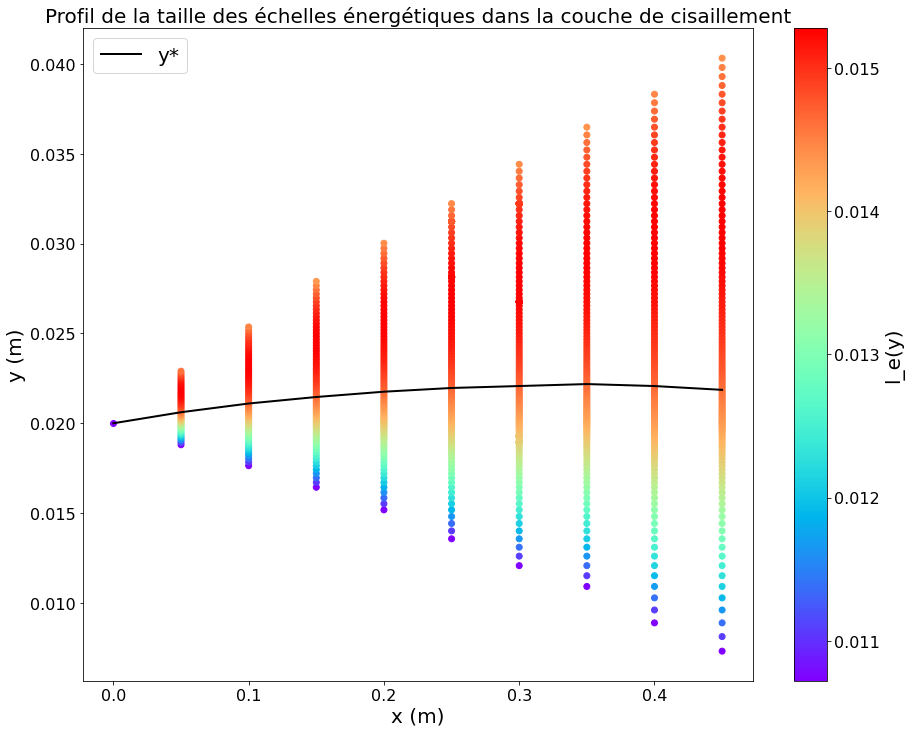

In [561]:


def plot_2d_energy_scale_shear_layer(df, x_values, _U_0 = U_0, delta_U = U_1 - U_0):
    fig, ax = plt.subplots(figsize=(15, 12))  # Increase the size of the figure
    
    # Use a standard colormap
    color_map = cm.get_cmap('rainbow')

    # Compute l_e values for all x_values and find the min and max
    l_e_values = []
    for x in x_values:
        # Compute the shear layer limits for this x
        _y_min, _y_max = compute_shear_layer_limit(df, x, _U_0, delta_U)
        
        df_x = df[(df['x'] == x) & (df['y'] >= _y_min) & (df['y'] <= _y_max)].copy()
        
        # Add l_e values to the list
        l_e_values.extend(df_x['l_e'].tolist())
        
        # Plot x vs y with a color from the colormap representing l_e
        sc = ax.scatter([x]*len(df_x), df_x['y'], c=df_x['l_e'], cmap=color_map)#, vmin=min(l_e_values), vmax=max(l_e_values))
    
    # Plot y_star vs x outside the loop
    y_star_values = [compute_y_star(data, x) for x in x_values]
    ax.plot(x_values, y_star_values, color='black', linewidth=2, label='y*')
    
    ax.set_xlabel('x (m)', fontsize = 20)
    ax.set_ylabel('y (m)', fontsize = 20)
    ax.set_title('Profil de la taille des échelles énergétiques dans la couche de cisaillement', fontsize = 20)
    
    # Increase the size of the tick labels
    ax.tick_params(axis='both', which='major', labelsize=16)
    
    # Add a colorbar
    cbar = fig.colorbar(sc, label='l_e(y)')
    cbar.set_label('l_e(y)', size=20)  # Increase the size of the colorbar label
    
    # Increase the size of the colorbar tick labels
    cbar.ax.tick_params(labelsize=16)
    
    # Add a legend
    ax.legend(loc='upper left', fontsize=20)

    plt.show()

# Test the function
x_values_coeur = [x for x in x_values if x < 0.462163]
plot_2d_energy_scale_shear_layer(data, x_values_coeur)

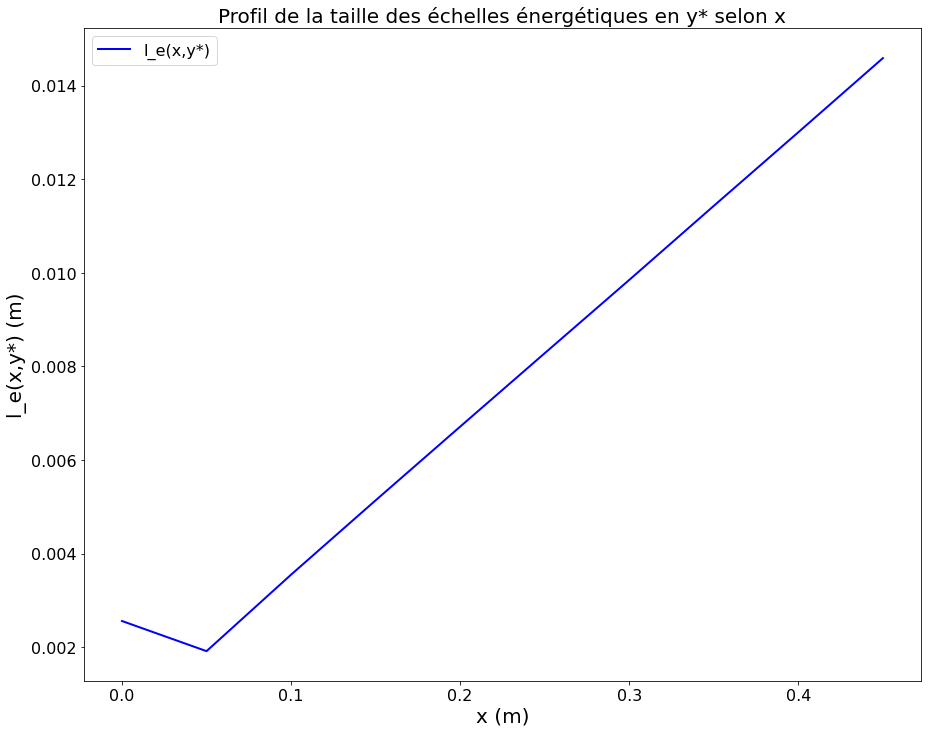

In [562]:
def plot_le_at_y_star(df, x_values, _U_0 = U_0, _U_1 = U_1):
    fig, ax = plt.subplots(figsize=(15, 12))  # Increase the size of the figure

    # Compute y_star and le values for all x_values
    y_star_values = []  # List to store y_star values
    le_at_y_star_values = []  # List to store le values at y_star
    for x in x_values:
        # Compute y_star for this x
        y_star = compute_y_star(df, x, _U_0, _U_1)
        y_star_values.append(y_star)

        # Get the le value at y_star for this x
        le_at_y_star = df[(df['x'] == x) & (df['y'] == y_star)]['l_e'].values[0]
        le_at_y_star_values.append(le_at_y_star)

    # Plot le at y_star vs x
    ax.plot(x_values, le_at_y_star_values, color='blue', linewidth=2, label='l_e(x,y*)')

    ax.set_xlabel('x (m)', fontsize = 20)
    ax.set_ylabel('l_e(x,y*) (m)', fontsize = 20)
    ax.set_title('Profil de la taille des échelles énergétiques en y* selon x', fontsize = 20)

    # Increase the size of the tick labels
    ax.tick_params(axis='both', which='major', labelsize=16)

    # Add a legend
    ax.legend(fontsize=16)

    plt.show()

# Test the function
x_values_coeur = [x for x in x_values if x < 0.462163]
plot_le_at_y_star(data, x_values_coeur)

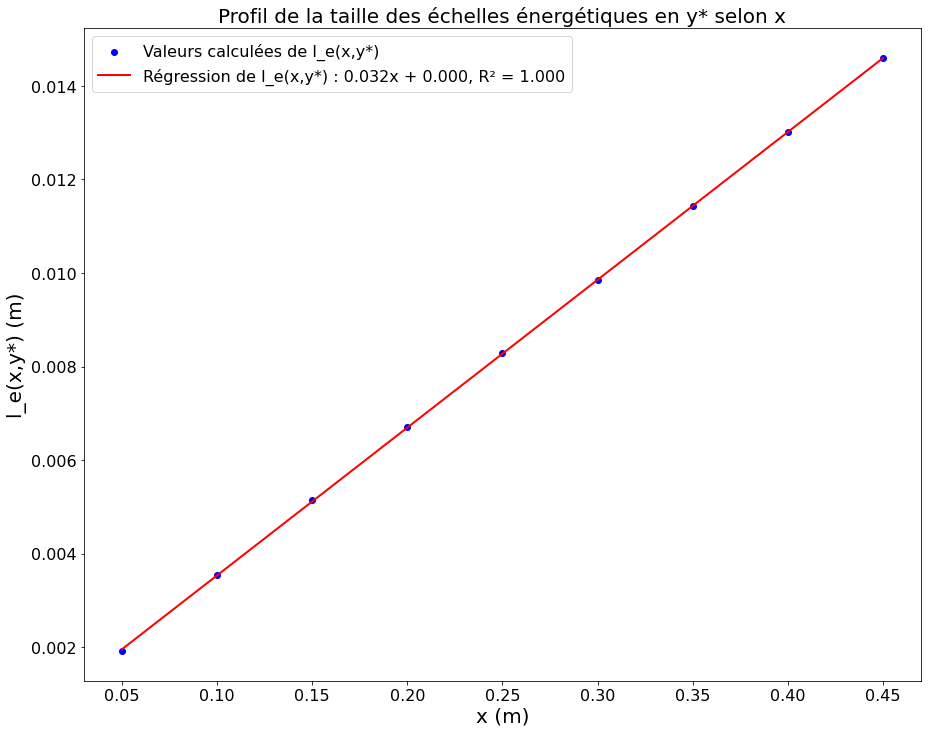

In [569]:
import matplotlib.pyplot as plt

def plot_le_at_y_star(df, x_values, _U_0 = U_0, _U_1 = U_1):
    fig, ax = plt.subplots(figsize=(15, 12))  # Increase the size of the figure

    # Compute y_star and le values for all x_values
    y_star_values = []  # List to store y_star values
    le_at_y_star_values = []  # List to store le values at y_star
    for x in x_values:
        # Compute y_star for this x
        y_star = compute_y_star(df, x, _U_0, _U_1)
        y_star_values.append(y_star)

        # Get the le value at y_star for this x
        le_at_y_star = df[(df['x'] == x) & (df['y'] == y_star)]['l_e'].values[0]
        le_at_y_star_values.append(le_at_y_star)

    # Remove the first value
    x_values = x_values[1:]
    le_at_y_star_values = le_at_y_star_values[1:]

    # Use numpy.polyfit to perform a linear regression
    coefficients = np.polyfit(x_values, le_at_y_star_values, 1)

    # Compute the fitted values
    fitted_values = np.polyval(coefficients, x_values)

    # Compute the R-squared value
    r_squared = np.corrcoef(le_at_y_star_values, fitted_values)[0, 1]**2

    # Plot le at y_star vs x as a scatter plot
    ax.scatter(x_values, le_at_y_star_values, color='blue', label='Valeurs calculées de l_e(x,y*)')

    # Plot the fitted curve
    ax.plot(x_values, fitted_values, 'r', linewidth=2, label=f'Régression de l_e(x,y*) : {coefficients[0]:.5f}x + {coefficients[1]:.5f}, R² = {r_squared:.5f}')

    ax.set_xlabel('x (m)', fontsize = 20)
    ax.set_ylabel('l_e(x,y*) (m)', fontsize = 20)
    ax.set_title('Profil de la taille des échelles énergétiques en y* selon x', fontsize = 20)

    # Increase the size of the tick labels
    ax.tick_params(axis='both', which='major', labelsize=16)

    # Add a legend
    ax.legend(fontsize=16)

    plt.show()

# Test the function
x_values_coeur = [x for x in x_values if x < 0.462163]
plot_le_at_y_star(data, x_values_coeur)

In [564]:
'''def plot_average_adimensional_kinetic_energy(df, x_values, _U_0 = U_0, _U_1 = U_1):
    plt.figure(figsize=(16, 10))
    
    # Create a list to store the adimensional y and k(y) values
    adim_data = []
    
    for x in x_values:
        # Compute y_star and delta
        y_star = compute_y_star(u_data, x)
        delta = shear_layer_thickness(u_data, x)

        df_x = df[df['x'] == x].copy()
        
        # Adimensionalize y and k(y)
        df_x['y_adim'] = (df_x['y'] - y_star) / delta
        df_x['k_adim'] = df_x['k(y)'] / (_U_1 - _U_0)**2
        
        # Append the adimensional values to adim_data
        adim_data.append(df_x[['y_adim', 'k_adim']])
    
    # Concatenate all DataFrames in adim_data
    df_adim = pd.concat(adim_data, ignore_index=True)
    
    # Group by y_adim and calculate the mean of k_adim
    df_adim_avg = df_adim.groupby('y_adim', as_index=False)['k_adim'].mean()
    
    # Plot the average adimensional k(y) vs y
    plt.plot(df_adim_avg['y_adim'], df_adim_avg['k_adim'], label='Average', color='blue')
    
    plt.xlabel('(y-y*)/delta', fontsize=14)
    plt.ylabel('k(y)/(U_1-U_0)^2', fontsize=14)
    plt.title("Average adimensional kinetic energy profile", fontsize=20)
    plt.legend()
    plt.grid(True)
    
    # Set x-axis limits and ticks
    plt.xlim(-5, 5)
    plt.xticks(range(-5, 6))
    
    plt.show()

# Test the function
x_values_coeur = [x for x in x_values if x < 0.462163]
plot_average_adimensional_kinetic_energy(data, x_values_coeur)'''

'def plot_average_adimensional_kinetic_energy(df, x_values, _U_0 = U_0, _U_1 = U_1):\n    plt.figure(figsize=(16, 10))\n    \n    # Create a list to store the adimensional y and k(y) values\n    adim_data = []\n    \n    for x in x_values:\n        # Compute y_star and delta\n        y_star = compute_y_star(u_data, x)\n        delta = shear_layer_thickness(u_data, x)\n\n        df_x = df[df[\'x\'] == x].copy()\n        \n        # Adimensionalize y and k(y)\n        df_x[\'y_adim\'] = (df_x[\'y\'] - y_star) / delta\n        df_x[\'k_adim\'] = df_x[\'k(y)\'] / (_U_1 - _U_0)**2\n        \n        # Append the adimensional values to adim_data\n        adim_data.append(df_x[[\'y_adim\', \'k_adim\']])\n    \n    # Concatenate all DataFrames in adim_data\n    df_adim = pd.concat(adim_data, ignore_index=True)\n    \n    # Group by y_adim and calculate the mean of k_adim\n    df_adim_avg = df_adim.groupby(\'y_adim\', as_index=False)[\'k_adim\'].mean()\n    \n    # Plot the average adimensional

In [565]:
'''def plot_max_difference(df, x_values, _U_0 = U_0, _U_1 = U_1):
    # Create a DataFrame to store the adimensional u(y) values for each x
    df_adim = pd.DataFrame()

    for x in x_values:
        # Compute y_star and delta
        y_star = compute_y_star(df, x)
        delta = shear_layer_thickness(df, x)

        df_x = df[df['x'] == x].copy()
        
        # Adimensionalize y and u(y)
        df_x['y_adim'] = (df_x['y'] - y_star) / delta
        df_x['u_adim'] = (df_x['u(y)'] - _U_0) / (_U_1 - _U_0)
        
        # Add the adimensional u(y) values to df_adim
        df_adim[x] = df_x.set_index('y_adim')['u_adim']

    # Compute the maximum difference at each y_adim
    df_adim['max_diff'] = df_adim.max(axis=1) - df_adim.min(axis=1)

    # Plot the maximum difference vs y_adim
    plt.figure(figsize=(10, 6))
    plt.plot(df_adim.index, df_adim['max_diff'])
    plt.xlabel('y adimensional')
    plt.ylabel('Max difference')
    plt.title('Maximum difference between adimensional velocity profiles')
    plt.grid(True)
    plt.show()

# Test the function
x_values_coeur = [x for x in x_values if x < 0.462163]
plot_max_difference(data, x_values_coeur)'''

"def plot_max_difference(df, x_values, _U_0 = U_0, _U_1 = U_1):\n    # Create a DataFrame to store the adimensional u(y) values for each x\n    df_adim = pd.DataFrame()\n\n    for x in x_values:\n        # Compute y_star and delta\n        y_star = compute_y_star(df, x)\n        delta = shear_layer_thickness(df, x)\n\n        df_x = df[df['x'] == x].copy()\n        \n        # Adimensionalize y and u(y)\n        df_x['y_adim'] = (df_x['y'] - y_star) / delta\n        df_x['u_adim'] = (df_x['u(y)'] - _U_0) / (_U_1 - _U_0)\n        \n        # Add the adimensional u(y) values to df_adim\n        df_adim[x] = df_x.set_index('y_adim')['u_adim']\n\n    # Compute the maximum difference at each y_adim\n    df_adim['max_diff'] = df_adim.max(axis=1) - df_adim.min(axis=1)\n\n    # Plot the maximum difference vs y_adim\n    plt.figure(figsize=(10, 6))\n    plt.plot(df_adim.index, df_adim['max_diff'])\n    plt.xlabel('y adimensional')\n    plt.ylabel('Max difference')\n    plt.title('Maximum differ